---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
---

# Optimizing the Aircraft Wing Weight Example {#sec-awwe-opt}

::: {.callout-note}
### Note
* This section demonstrates optimization of the Aircraft Wing Weight Example (AWWE) function
* We compare three optimization methods:
  - **SpotOptim**: Bayesian optimization with Gaussian Process surrogate
  - **Nelder-Mead**: Derivative-free simplex method from scipy.optimize
  - **BFGS**: Quasi-Newton method from scipy.optimize
* The following Python packages are imported:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from spotoptim import SpotOptim
import time
import pprint

:::

## The AWWE Objective Function

We use the same AWWE function from @sec-awwe, which models the weight of an unpainted light aircraft wing. The function accepts inputs in the unit cube $[0,1]^9$ and returns the wing weight.

In [2]:
def wingwt(x):
    """
    Aircraft Wing Weight function.
    
    Args:
        x: array-like of 9 values in [0,1]
           [Sw, Wfw, A, L, q, l, Rtc, Nz, Wdg]
    
    Returns:
        Wing weight (scalar)
    """
    # Ensure x is a 2D array for batch evaluation
    x = np.atleast_2d(x)
    
    # Transform from unit cube to natural scales
    Sw = x[:, 0] * (200 - 150) + 150 
    Wfw = x[:, 1] * (300 - 220) + 220 
    A = x[:, 2] * (10 - 6) + 6 
    L = (x[:, 3] * (10 - (-10)) - 10) * np.pi/180
    q = x[:, 4] * (45 - 16) + 16 
    l = x[:, 5] * (1 - 0.5) + 0.5  
    Rtc = x[:, 6] * (0.18 - 0.08) + 0.08
    Nz = x[:, 7] * (6 - 2.5) + 2.5
    Wdg = x[:, 8] * (2500 - 1700) + 1700
    
    # Calculate weight on natural scale
    W = 0.036 * Sw**0.758 * Wfw**0.0035 * (A/np.cos(L)**2)**0.6 * q**0.006 
    W = W * l**0.04 * (100*Rtc/np.cos(L))**(-0.3) * (Nz*Wdg)**(0.49)
    
    return W.ravel()


# Wrapper for scipy.optimize (expects 1D input, returns scalar)
def wingwt_scipy(x):
    return float(wingwt(x.reshape(1, -1))[0])

## Baseline Configuration

The baseline Cessna C172 Skyhawk configuration (coded in unit cube):

In [3]:
baseline_coded = np.array([0.48, 0.4, 0.38, 0.5, 0.62, 0.344, 0.4, 0.37, 0.38])
baseline_weight = wingwt(baseline_coded)[0]
print(f"Baseline wing weight: {baseline_weight:.2f} lb")

Baseline wing weight: 233.91 lb


## Optimization Setup

We'll optimize the AWWE function starting from the baseline configuration using three different methods:

1. **SpotOptim**: Bayesian optimization (good for expensive black-box functions)
2. **Nelder-Mead**: Derivative-free simplex method (robust but can be slow)
3. **BFGS**: Quasi-Newton method (fast but requires smooth functions)

In [4]:
# Starting point (baseline configuration)
x0 = baseline_coded.copy()

# Bounds for all methods (unit cube)
bounds = [(0, 1)] * 9

# Number of function evaluations budget
max_evals = 30

print(f"Starting point: {x0}")
print(f"Starting weight: {baseline_weight:.2f} lb")

Starting point: [0.48  0.4   0.38  0.5   0.62  0.344 0.4   0.37  0.38 ]
Starting weight: 233.91 lb


## Method 1: SpotOptim (Surrogate Model Based Optimization)

In [5]:
# Start timing
start_time = time.time()

# Configure SpotOptim
optimizer_spot = SpotOptim(
    fun=wingwt,
    bounds=bounds,
    x0=None,
    max_iter=max_evals,
    n_initial=10,  # Initial design points
    var_name=['Sw', 'Wfw', 'A', 'L', 'q', 'l', 'Rtc', 'Nz', 'Wdg'],
    acquisition='y',  # ei: Expected Improvement
    max_surrogate_points=100,
    seed=42,
    verbose=True,
    tensorboard_log=True,
    tensorboard_clean=True
)


Removed old TensorBoard logs: runs/spotoptim_20251117_194133
Cleaned 1 old TensorBoard log directory
TensorBoard logging enabled: runs/spotoptim_20251117_194303


## Design Table

In [6]:

pprint.pprint(optimizer_spot.print_design_table())

('| name   | type   |   lower |   upper |   default | trans   |\n'
 '|--------|--------|---------|---------|-----------|---------|\n'
 '| Sw     | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| Wfw    | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| A      | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| L      | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| q      | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| l      | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| Rtc    | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| Nz     | float  |  0.0000 |  1.0000 |    0.5000 | -       |\n'
 '| Wdg    | float  |  0.0000 |  1.0000 |    0.5000 | -       |')


## Run optimization

In [7]:
result_spot = optimizer_spot.optimize()

Initial best: f(x) = 212.219714
Iteration 1: New best f(x) = 142.977744
Iteration 2: New best f(x) = 140.904175
Iteration 3: New best f(x) = 120.465251
Iteration 4: f(x) = 121.575842
Iteration 5: New best f(x) = 120.101053
Iteration 6: New best f(x) = 119.997018
Iteration 7: f(x) = 120.018134
Iteration 8: New best f(x) = 119.958665
Iteration 9: f(x) = 120.386522
Iteration 10: New best f(x) = 119.691338
Iteration 11: New best f(x) = 119.530080
Iteration 12: f(x) = 119.539469
Iteration 13: New best f(x) = 119.503677
Iteration 14: f(x) = 119.503691
Iteration 15: New best f(x) = 119.503672
Iteration 16: f(x) = 119.503718
Iteration 17: f(x) = 119.503685
Iteration 18: f(x) = 119.503693
Iteration 19: f(x) = 119.503726
Iteration 20: f(x) = 119.503749
TensorBoard writer closed. View logs with: tensorboard --logdir=runs/spotoptim_20251117_194303


In [8]:

# End timing
spot_time = time.time() - start_time

print(f"\nSpotOptim Results:")
print(f"  Best weight: {result_spot.fun:.4f} lb")
print(f"  Function evaluations: {result_spot.nfev}")
print(f"  Time elapsed: {spot_time:.2f} seconds")
print(f"  Success: {result_spot.success}")


SpotOptim Results:
  Best weight: 119.5037 lb
  Function evaluations: 30
  Time elapsed: 6.79 seconds
  Success: True


In [9]:
optimizer_spot.print_best()


Best Solution Found:
--------------------------------------------------
  Sw: 0.0000
  Wfw: 0.0000
  A: 0.0000
  L: 0.5000
  q: 0.0000
  l: 0.0000
  Rtc: 1.0000
  Nz: 0.0000
  Wdg: 0.0000
  Objective Value: 119.5037
  Total Evaluations: 30


## Result Table

In [10]:
pprint.pprint(optimizer_spot.print_results_table(show_importance=True))

('| name   | type   |   lower |   upper |   tuned | trans   |   importance | '
 'stars   |\n'
 '|--------|--------|---------|---------|---------|---------|--------------|---------|\n'
 '| Sw     | float  |  0.0000 |  1.0000 |  0.0000 | -       |         9.52 | '
 '*       |\n'
 '| Wfw    | float  |  0.0000 |  1.0000 |  0.0000 | -       |        12.76 | '
 '*       |\n'
 '| A      | float  |  0.0000 |  1.0000 |  0.0000 | -       |        14.11 | '
 '*       |\n'
 '| L      | float  |  0.0000 |  1.0000 |  0.5000 | -       |         4.30 | '
 '*       |\n'
 '| q      | float  |  0.0000 |  1.0000 |  0.0000 | -       |         6.10 | '
 '*       |\n'
 '| l      | float  |  0.0000 |  1.0000 |  0.0000 | -       |        11.05 | '
 '*       |\n'
 '| Rtc    | float  |  0.0000 |  1.0000 |  1.0000 | -       |        13.87 | '
 '*       |\n'
 '| Nz     | float  |  0.0000 |  1.0000 |  0.0000 | -       |        14.03 | '
 '*       |\n'
 '| Wdg    | float  |  0.0000 |  1.0000 |  0.0000 | -       |   

## Progress of the Optimization

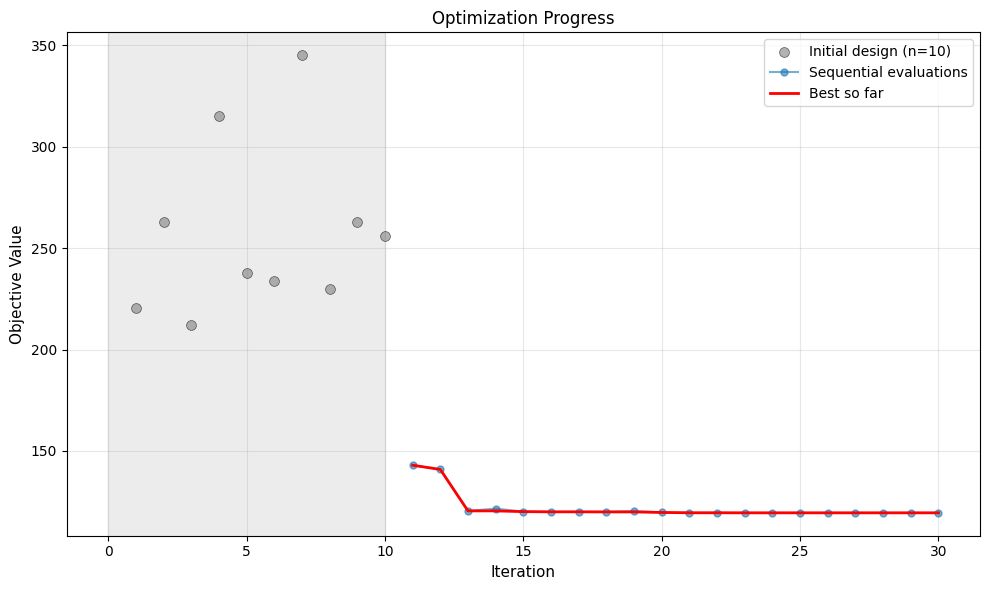

In [11]:
optimizer_spot.plot_progress(log_y=False)

## Contour Plots of Most Important Hyperparameters

Plotting surrogate contours for top 3 most important parameters:
  Wdg: importance = 14.27% (type: float)
  A: importance = 14.11% (type: float)
  Nz: importance = 14.03% (type: float)

Generating 3 surrogate plots...
  Plotting Wdg vs A


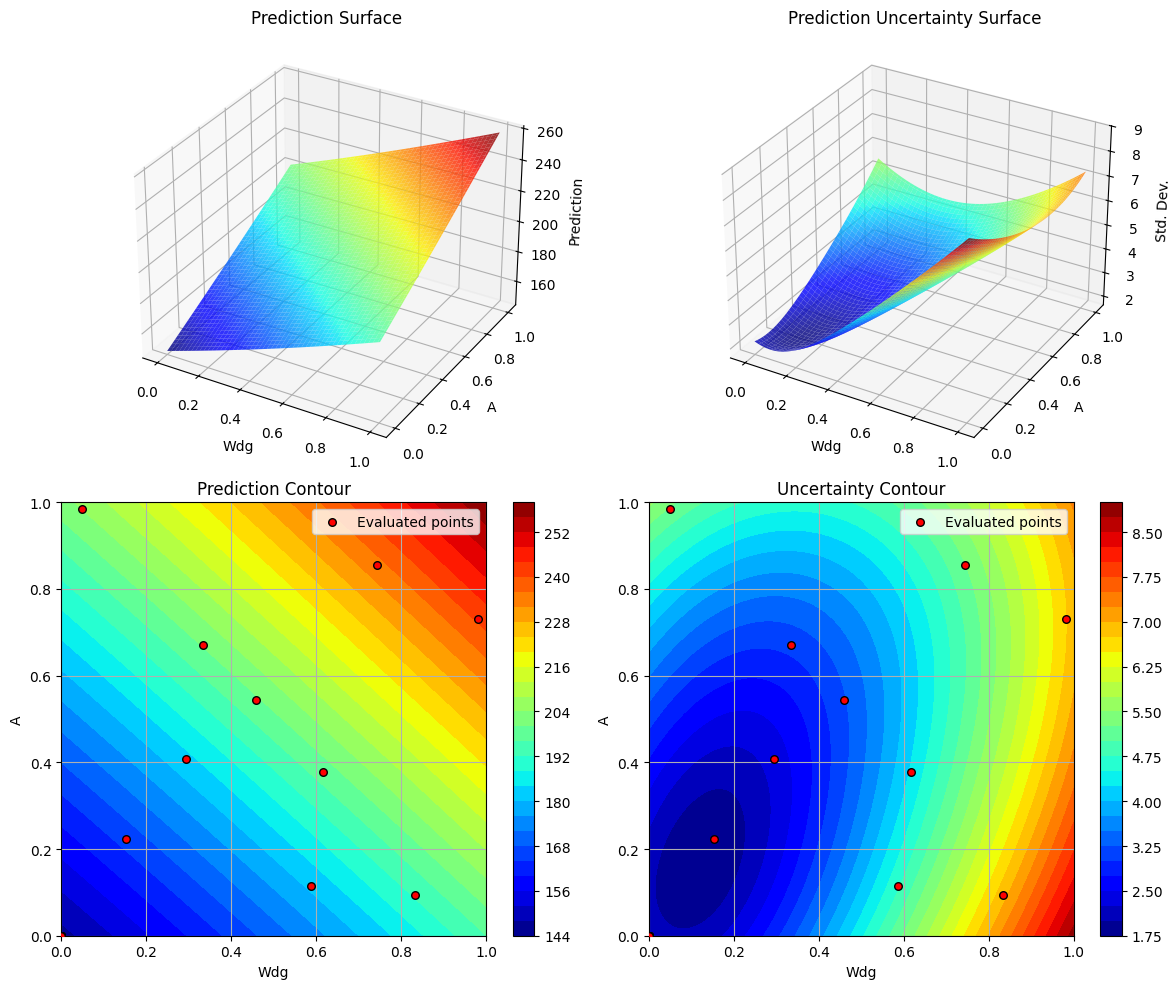

  Plotting Wdg vs Nz


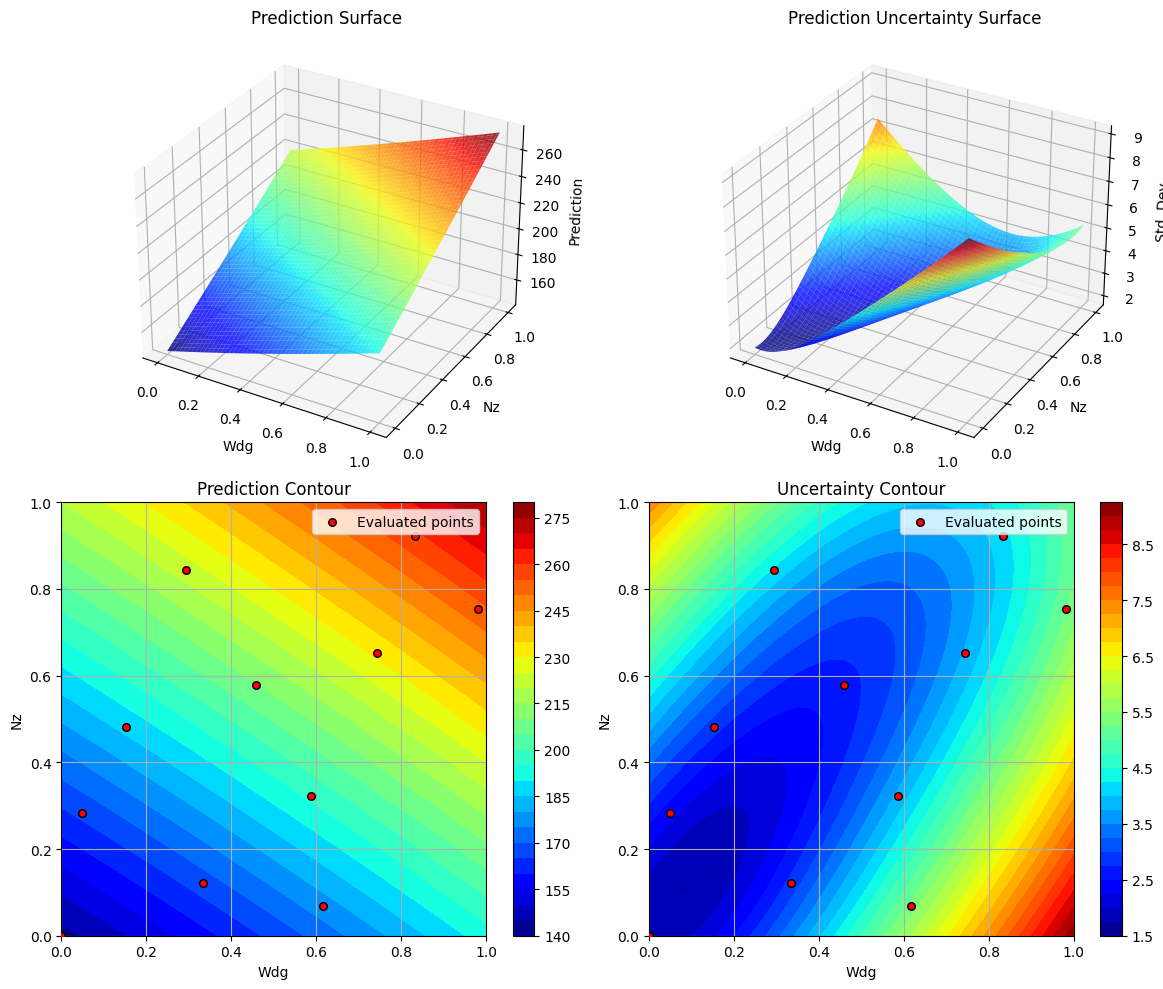

  Plotting A vs Nz


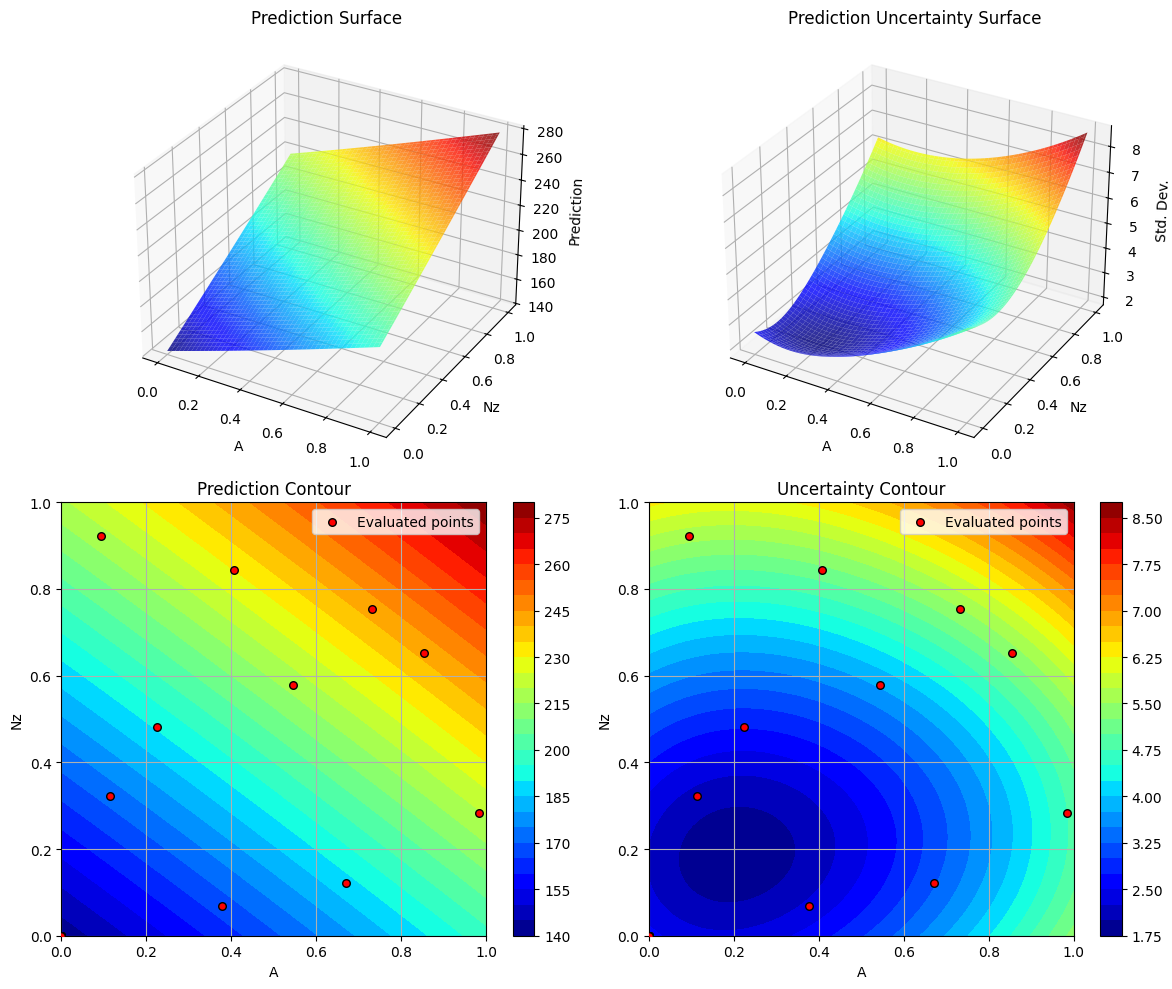

In [12]:
optimizer_spot.plot_important_hyperparameter_contour(max_imp=3)

## Method 2: Nelder-Mead Simplex

In [13]:
print("\n" + "=" * 60)
print("Running Nelder-Mead Simplex...")
print("=" * 60)

# Start timing
start_time = time.time()

# Run optimization
result_nm = minimize(
    wingwt_scipy,
    x0=x0,
    method='Nelder-Mead',
    bounds=bounds,
    options={'maxfev': max_evals, 'disp': True}
)

# End timing
nm_time = time.time() - start_time

print(f"\nNelder-Mead Results:")
print(f"  Best weight: {result_nm.fun:.4f} lb")
print(f"  Function evaluations: {result_nm.nfev}")
print(f"  Time elapsed: {nm_time:.2f} seconds")
print(f"  Success: {result_nm.success}")


Running Nelder-Mead Simplex...

Nelder-Mead Results:
  Best weight: 220.5449 lb
  Function evaluations: 30
  Time elapsed: 0.00 seconds
  Success: False


## Method 3: BFGS (Quasi-Newton)

In [ ]:
print("\n" + "=" * 60)
print("Running BFGS (Quasi-Newton)...")
print("=" * 60)


# Start timing
start_time = time.time()

# Run optimization
result_bfgs = minimize(
    wingwt_scipy,
    x0=x0,
    method='L-BFGS-B',  # Bounded BFGS
    bounds=bounds,
    options={'maxfun': max_evals, 'disp': True}
)

# End timing
bfgs_time = time.time() - start_time

print(f"\nBFGS Results:")
print(f"  Best weight: {result_bfgs.fun:.4f} lb")
print(f"  Function evaluations: {result_bfgs.nfev}")
print(f"  Time elapsed: {bfgs_time:.2f} seconds")
print(f"  Success: {result_bfgs.success}")


Running BFGS (Quasi-Newton)...

BFGS Results:
  Best weight: 119.5245 lb
  Function evaluations: 20
  Time elapsed: 0.00 seconds
  Success: False


## Comparison of Results

In [15]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Method': ['Baseline', 'SpotOptim', 'Nelder-Mead', 'BFGS'],
    'Best Weight (lb)': [
        baseline_weight,
        result_spot.fun,
        result_nm.fun,
        result_bfgs.fun
    ],
    'Improvement (%)': [
        0.0,
        (baseline_weight - result_spot.fun) / baseline_weight * 100,
        (baseline_weight - result_nm.fun) / baseline_weight * 100,
        (baseline_weight - result_bfgs.fun) / baseline_weight * 100
    ],
    'Function Evals': [
        1,
        result_spot.nfev,
        result_nm.nfev,
        result_bfgs.nfev
    ],
    'Time (s)': [
        0.0,
        spot_time,
        nm_time,
        bfgs_time
    ],
    'Success': [
        True,
        result_spot.success,
        result_nm.success,
        result_bfgs.success
    ]
})

print("\n" + "=" * 80)
print("OPTIMIZATION COMPARISON")
print("=" * 80)
print(comparison.to_string(index=False))
print("=" * 80)


OPTIMIZATION COMPARISON
     Method  Best Weight (lb)  Improvement (%)  Function Evals  Time (s)  Success
   Baseline        233.908405         0.000000               1  0.000000     True
  SpotOptim        119.503672        48.910057              30  6.786699     True
Nelder-Mead        220.544928         5.713124              30  0.001126    False
       BFGS        119.524458        48.901170              20  0.000692    False


## Visualization: Convergence Plots

### SpotOptim Convergence

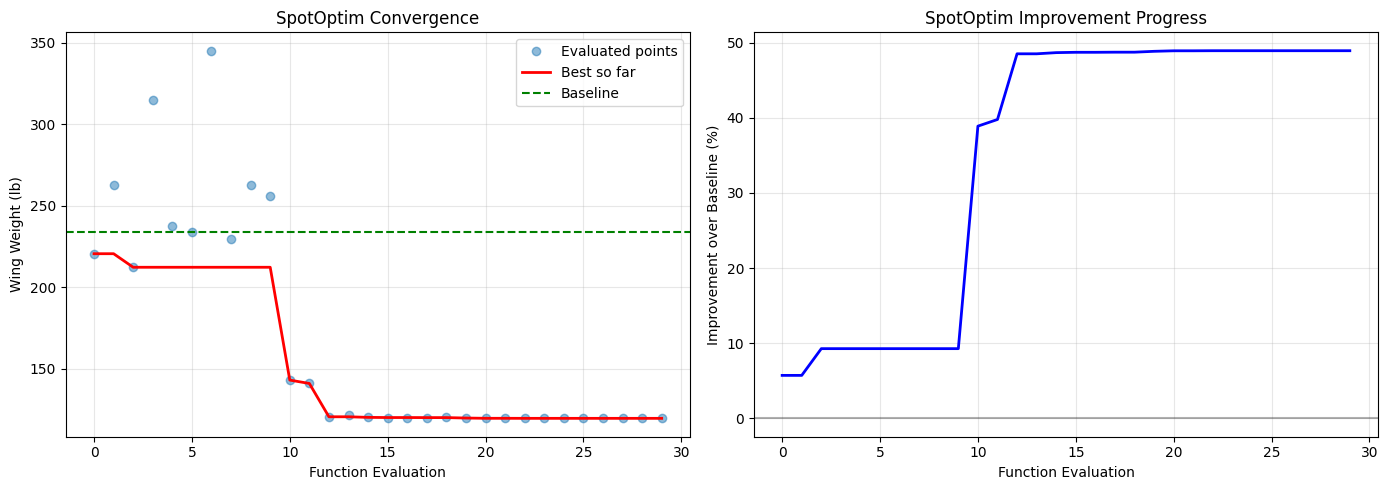

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Best value over iterations
y_history = optimizer_spot.y_
best_so_far = np.minimum.accumulate(y_history)

ax1.plot(range(len(y_history)), y_history, 'o', alpha=0.5, label='Evaluated points')
ax1.plot(range(len(best_so_far)), best_so_far, 'r-', linewidth=2, label='Best so far')
ax1.axhline(y=baseline_weight, color='g', linestyle='--', label='Baseline')
ax1.set_xlabel('Function Evaluation')
ax1.set_ylabel('Wing Weight (lb)')
ax1.set_title('SpotOptim Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Improvement over baseline
improvement = (baseline_weight - best_so_far) / baseline_weight * 100
ax2.plot(range(len(improvement)), improvement, 'b-', linewidth=2)
ax2.set_xlabel('Function Evaluation')
ax2.set_ylabel('Improvement over Baseline (%)')
ax2.set_title('SpotOptim Improvement Progress')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## Optimal Parameter Values

Let's examine the optimal parameter values found by each method:

In [17]:
# Parameter names
param_names = ['Sw', 'Wfw', 'A', 'L', 'q', 'l', 'Rtc', 'Nz', 'Wdg']

# Transform from unit cube to natural scales
def decode_params(x):
    scales = [
        (150, 200),      # Sw
        (220, 300),      # Wfw
        (6, 10),         # A
        (-10, 10),       # L (degrees)
        (16, 45),        # q
        (0.5, 1),        # l
        (0.08, 0.18),    # Rtc
        (2.5, 6),        # Nz
        (1700, 2500)     # Wdg
    ]
    decoded = []
    for i, (low, high) in enumerate(scales):
        decoded.append(x[i] * (high - low) + low)
    return decoded

# Create comparison table
baseline_decoded = decode_params(baseline_coded)
spot_decoded = decode_params(result_spot.x)
nm_decoded = decode_params(result_nm.x)
bfgs_decoded = decode_params(result_bfgs.x)

param_comparison = pd.DataFrame({
    'Parameter': param_names,
    'Baseline': baseline_decoded,
    'SpotOptim': spot_decoded,
    'Nelder-Mead': nm_decoded,
    'BFGS': bfgs_decoded
})

print("\n" + "=" * 100)
print("OPTIMAL PARAMETER VALUES (Natural Scale)")
print("=" * 100)
print(param_comparison.to_string(index=False))
print("=" * 100)


OPTIMAL PARAMETER VALUES (Natural Scale)
Parameter  Baseline   SpotOptim  Nelder-Mead        BFGS
       Sw   174.000  150.000000   173.923947  150.000000
      Wfw   252.000  220.000000   254.534988  231.208496
        A     7.520    6.000000     7.484111    6.000000
        L     0.000    0.000531    -0.126137    0.000000
        q    33.980   16.000000    34.156818   16.000000
        l     0.672    0.500000     0.674613    0.500000
      Rtc     0.120    0.180000     0.124872    0.180000
       Nz     3.795    2.500000     3.427058    2.500000
      Wdg  2004.000 1700.000000  2028.938270 1700.000000


## Analysis of Optimal Solutions

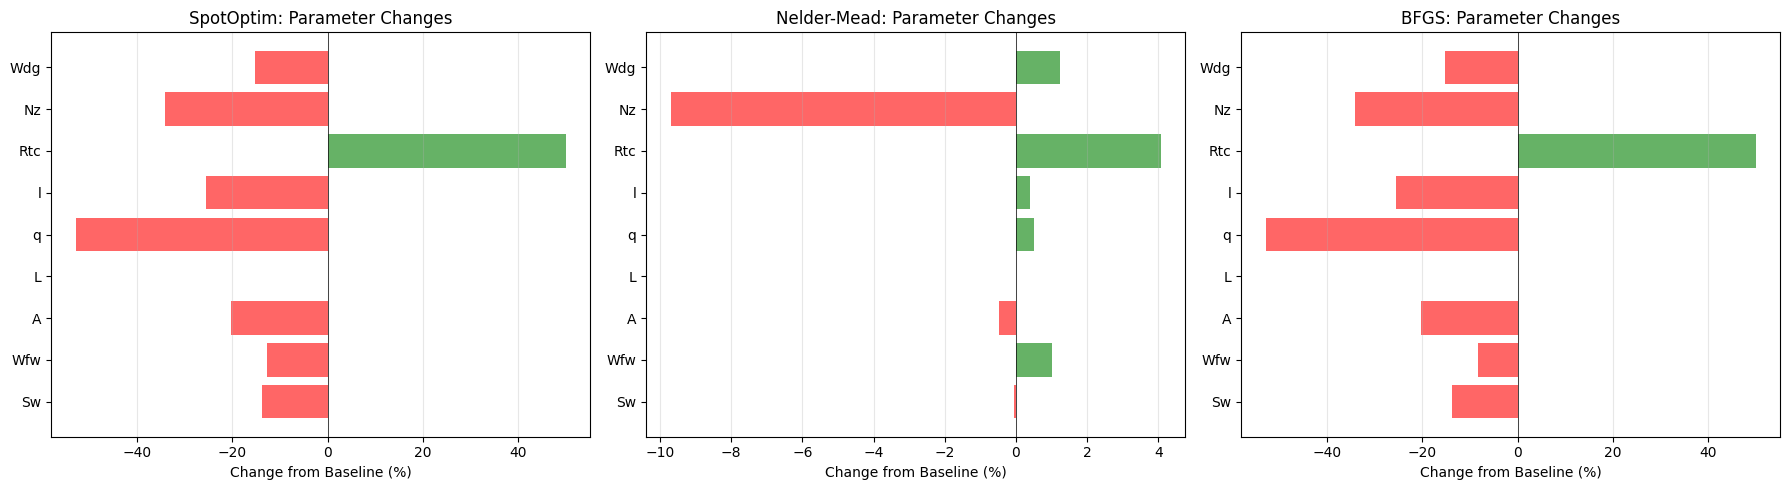

In [18]:
# Calculate percentage changes from baseline
changes_spot = [(spot_decoded[i] - baseline_decoded[i]) / baseline_decoded[i] * 100 
                for i in range(len(param_names))]
changes_nm = [(nm_decoded[i] - baseline_decoded[i]) / baseline_decoded[i] * 100 
              for i in range(len(param_names))]
changes_bfgs = [(bfgs_decoded[i] - baseline_decoded[i]) / baseline_decoded[i] * 100 
                for i in range(len(param_names))]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, changes, method in zip(axes, 
                                 [changes_spot, changes_nm, changes_bfgs],
                                 ['SpotOptim', 'Nelder-Mead', 'BFGS']):
    colors = ['red' if c < 0 else 'green' for c in changes]
    ax.barh(param_names, changes, color=colors, alpha=0.6)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Change from Baseline (%)')
    ax.set_title(f'{method}: Parameter Changes')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Key Insights from Optimal Solutions

In [19]:
# Find parameters with largest changes for each method
def analyze_changes(decoded, baseline_decoded, method_name):
    changes = {param_names[i]: decoded[i] - baseline_decoded[i] 
               for i in range(len(param_names))}
    sorted_changes = sorted(changes.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n{method_name} - Top 5 Parameter Changes:")
    print("-" * 50)
    for param, change in sorted_changes[:5]:
        idx = param_names.index(param)
        pct = change / baseline_decoded[idx] * 100
        print(f"  {param:5s}: {change:+8.2f} ({pct:+6.1f}%)")

analyze_changes(spot_decoded, baseline_decoded, "SpotOptim")
analyze_changes(nm_decoded, baseline_decoded, "Nelder-Mead")
analyze_changes(bfgs_decoded, baseline_decoded, "BFGS")


SpotOptim - Top 5 Parameter Changes:
--------------------------------------------------
  Wdg  :  -304.00 ( -15.2%)
  Wfw  :   -32.00 ( -12.7%)
  Sw   :   -24.00 ( -13.8%)
  q    :   -17.98 ( -52.9%)
  A    :    -1.52 ( -20.2%)

Nelder-Mead - Top 5 Parameter Changes:
--------------------------------------------------
  Wdg  :   +24.94 (  +1.2%)
  Wfw  :    +2.53 (  +1.0%)
  Nz   :    -0.37 (  -9.7%)
  q    :    +0.18 (  +0.5%)
  L    :    -0.13 (  -inf%)

BFGS - Top 5 Parameter Changes:
--------------------------------------------------
  Wdg  :  -304.00 ( -15.2%)
  Sw   :   -24.00 ( -13.8%)
  Wfw  :   -20.79 (  -8.3%)
  q    :   -17.98 ( -52.9%)
  A    :    -1.52 ( -20.2%)


## Method Efficiency Comparison

In [20]:
# Calculate efficiency metrics
efficiency = pd.DataFrame({
    'Method': ['SpotOptim', 'Nelder-Mead', 'BFGS'],
    'Weight Reduction (lb)': [
        baseline_weight - result_spot.fun,
        baseline_weight - result_nm.fun,
        baseline_weight - result_bfgs.fun
    ],
    'Evals to Best': [
        np.argmin(optimizer_spot.y_) + 1,
        result_nm.nfev,
        result_bfgs.nfev
    ],
    'Time per Eval (ms)': [
        spot_time / result_spot.nfev * 1000,
        nm_time / result_nm.nfev * 1000,
        bfgs_time / result_bfgs.nfev * 1000
    ]
})

print("\n" + "=" * 80)
print("METHOD EFFICIENCY METRICS")
print("=" * 80)
print(efficiency.to_string(index=False))
print("=" * 80)


METHOD EFFICIENCY METRICS
     Method  Weight Reduction (lb)  Evals to Best  Time per Eval (ms)
  SpotOptim             114.404734             25          226.223302
Nelder-Mead              13.363478             30            0.037535
       BFGS             114.383947             20            0.034606


## Visualization: 2D Slices of Optimal Solutions

Let's visualize how the optimal solutions compare in the most important 2D subspaces:

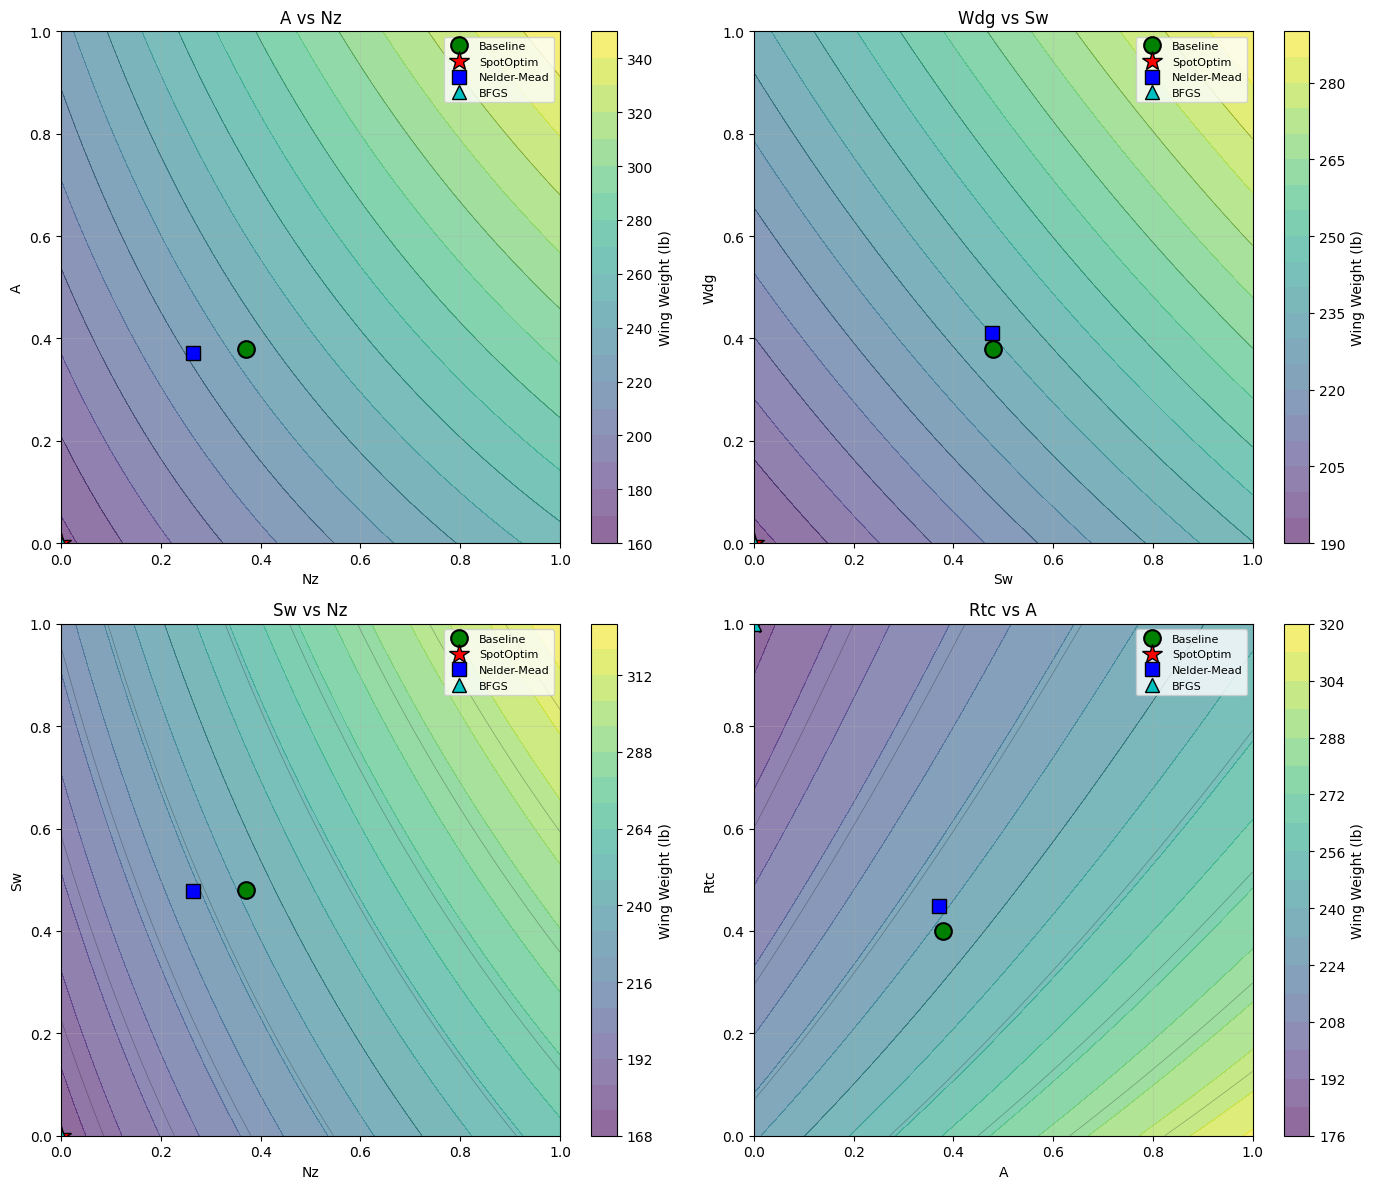

In [21]:
# Create 2D slices showing optimal points
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Important parameter pairs based on sensitivity analysis
pairs = [
    (7, 2),  # Nz vs A (load factor vs aspect ratio)
    (0, 8),  # Sw vs Wdg (wing area vs gross weight)
    (7, 0),  # Nz vs Sw (load factor vs wing area)
    (2, 6)   # A vs Rtc (aspect ratio vs thickness ratio)
]

for ax, (i, j) in zip(axes.flat, pairs):
    # Create meshgrid for contour plot
    x_range = np.linspace(0, 1, 50)
    y_range = np.linspace(0, 1, 50)
    X, Y = np.meshgrid(x_range, y_range)
    
    # Evaluate function on grid (fixing other parameters at baseline)
    Z = np.zeros_like(X)
    for ii in range(X.shape[0]):
        for jj in range(X.shape[1]):
            point = baseline_coded.copy()
            point[i] = X[ii, jj]
            point[j] = Y[ii, jj]
            Z[ii, jj] = wingwt(point)[0]
    
    # Plot contours
    contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
    ax.contour(X, Y, Z, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    
    # Plot optimal points
    ax.plot(baseline_coded[i], baseline_coded[j], 'go', markersize=12, 
            label='Baseline', markeredgecolor='black', markeredgewidth=1.5)
    ax.plot(result_spot.x[i], result_spot.x[j], 'r*', markersize=15, 
            label='SpotOptim', markeredgecolor='black', markeredgewidth=1)
    ax.plot(result_nm.x[i], result_nm.x[j], 'bs', markersize=10, 
            label='Nelder-Mead', markeredgecolor='black', markeredgewidth=1)
    ax.plot(result_bfgs.x[i], result_bfgs.x[j], 'c^', markersize=10, 
            label='BFGS', markeredgecolor='black', markeredgewidth=1)
    
    ax.set_xlabel(param_names[i])
    ax.set_ylabel(param_names[j])
    ax.set_title(f'{param_names[j]} vs {param_names[i]}')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(contour, ax=ax, label='Wing Weight (lb)')

plt.tight_layout()
plt.show()

## Conclusion

This analysis demonstrates the application of different optimization methods to the Aircraft Wing Weight Example. Key takeaways:

1. **SpotOptim** provides efficient global optimization with good exploration of the design space
2. **Nelder-Mead** offers robust derivative-free optimization but may require more evaluations
3. **BFGS** converges quickly for smooth problems but can get trapped in local minima

For aircraft design problems with expensive simulations, Bayesian optimization (SpotOptim) offers the best balance of efficiency and solution quality, making it particularly suitable for real-world engineering applications.

## Jupyter Notebook

:::{.callout-note}

* The Jupyter-Notebook of this lecture is available on GitHub in the [Hyperparameter-Tuning-Cookbook Repository](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook)

:::